<h2> NHL team distance traveled by season </h2>

NHL teams face pretty grueling travel schedules throughout their 82 game seasons and they typically don't play series-style games like MLB teams. In other words, they are constantly moving from city to city, often immediately after finishing a night game. There have been a number of analyses on NHL travel schedule and team performance and it appears that there is not much correlation between how well teams do in a season and how much they've traveled. On the other hand, there does appear to be some relationship between <em>direction</em> traveled and goalie performance in the NHL. Connection to performance aside, it's an interesting data point to look at for the league over any individual season. 

If you run the notebook and look at the bar plot, you'll immediately notice the well known East-West travel disparity: western conference teams tend to travel much more than the closely clustered eastern conference teams. The NHL began in the northeast U.S. and southest Canada and expanded westward and southward. Thus the density of teams decreases as you move west and south so these teams end of traveling more. 

This notebook scrapes the NHL schedule for a given year and calculates the approximate distance each team will travel. The results are plotted in a bar graph where the teams with the most miles traveled are on the left and least on the right. The bars are shaded by longitude which shows the East-West disparity in miles travleled. Note that international games before 2023 are ignored (there is no information on their location on NHL Reference before 2023)! The only input needed is the year of the season you want to examine. It can be specified in the third cell. 

Enjoy and please let me know if you have comments or suggestions!

In [1]:
#Get some packages
import geopandas
import geopy
import pandas as pd
import numpy as np
from haversine import haversine,Unit
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
#Define which year you want to look at. Tested back to 1995, beware earlier seasons...
year = '2023'

**It is recommended that you do not run the cell below and instead use the pre-computed team location dataframe saved as nhl_team_location_data.pkl**. The latitude longitude calculations are fairly expensive (for such a trivial result) and only need to be done once. Thus you should use the existing dataframe unless you want to mess around with the team info or put in arena-specific location data. 

In [3]:
teams = {'team':['Florida Panthers',
                'Toronto Maple Leafs',
                'Tampa Bay Lightning',
                'Boston Bruins',
                'Buffalo Sabres',
                'Detroit Red Wings',
                'Ottawa Senators',
                'Montreal Canadiens',
                'Carolina Hurricanes',
                'New York Rangers',
                'Pittsburgh Penguins',
                'Washington Capitals',
                'New York Islanders',
                'Columbus Blue Jackets',
                'New Jersey Devils',
                'Philadelphia Flyers',
                'Colorado Avalanche',
                'Minnesota Wild',
                'St. Louis Blues',
                'Dallas Stars',
                'Nashville Predators',
                'Winnipeg Jets',
                'Chicago Blackhawks',
                'Arizona Coyotes',
                'Calgary Flames',
                'Edmonton Oilers',
                'Los Angeles Kings',
                'Vegas Golden Knights',
                'Vancouver Canucks',
                'San Jose Sharks',
                'Anaheim Ducks',
                'Seattle Kraken',
                'Atlanta Thrashers',
                'Phoenix Coyotes',
                'Mighty Ducks of Anaheim',
                'Hartford Whalers',
                'Quebec Nordiques'], 
         'city':['Sunrise','Toronto','Tampa Bay','Boston','Buffalo',
                'Detroit','Ottawa','Montreal','Charlotte','Manhattan',
                'Pittsburgh','Washington','Brooklyn','Columbus','Newark',
                'Philadelphia','Denver','St. Paul','St. Louis','Dallas',
                'Nashville','Winnipeg','Chicago','Phoenix','Calgary',
                'Edmonton','Los Angeles','Las Vegas','Vancouver','San Jose',
                'Anaheim','Seattle','Atlanta','Phoenix','Anaheim','Hartford',
                'Quebec City'], 
         'state':['FL','ON','FL','MA','NY','MI','ON','QC','NC','NY',
                 'PA','DC','NY','OH','NJ','PA','CO','MN','MO','TX',
                 'TN','MB','IL','AZ','AB','AB','CA','NV','BC','CA',
                 'CA','WA','GA','AZ','CA','CT','QC']}

#Turn it into a dataframe
df = pd.DataFrame(teams)

#Instantiate the locator
locator = geopy.geocoders.Nominatim(user_agent="myGeocoder")

#Get latitude and longitude using the locator
df['latitude'] = df.apply(lambda x: locator.geocode(x['city']+', '+x['state']).latitude,axis=1)
df['longitude'] = df.apply(lambda x: locator.geocode(x['city']+', '+x['state']).longitude,axis=1)

#Let's add some columns to df that we will update as we go through the schedule
df['distance_traveled'] = 0
df['date_previous_game'] = 'none'
df['last_team_played'] = 'none'
df['last_status'] = 'home'
df['last_latitude'] = df['latitude']
df['last_longitude'] = df['longitude']

#Save dataframe for later use since locator is expensive
df.to_pickle('nhl_team_location_data.pkl')

In [4]:
#Read in previously saved team location data
df = pd.read_pickle("nhl_team_location_data.pkl")

In [5]:
#Now let's read in the schedule for the chosen season from hockey-reference using pandas.
#We want the first table that it scrapes
df_sched = pd.read_html('https://www.hockey-reference.com/leagues/NHL_'+year+'_games.html')[0]

#There are a few games in niether team's home arena in 2023 that are easily handled. These are
#recorded in the Notes column. The NHL's Global Series and other international games date
#back to 1993 but no good info is available from hockey-reference until 2022-2023 so
#we ignore these games. Fill all of the normal games with 'none'

df_sched['Notes'] = df_sched['Notes'].fillna('none')
df_sched['City'] = 'none'
df_sched['State'] = 'none'

#2022-2023 season had a few international games
if year == '2023':
    #Edit the neutral game site Notes to only include the location so it can be fed
    #into the locator
    df_sched.loc[df_sched['Notes'] == 'at (Prague, CZ)',['City','State']] = ['Prague', 'CZ']
    df_sched.loc[df_sched['Notes'] == 'at Nokia Arena (Tampere, FI)',['City','State']] = ['Tampere', 'FI']
    df_sched.loc[df_sched['Notes'] == 'at Fenway Park (Boston, MA)',['City','State']] = ['Boston', 'MA']
    df_sched.loc[df_sched['Notes'] == 'at Carter-Finley Stadium (Raleigh, NC)',['City','State']] = ['Raleigh', 'NC']
else:
    df_sched['Notes'] = 'none'

**Schedule loop**

Now loop through the schedule and update each team's distance traveled. A few things to note here: 1. We assume a simple travel schedule: teams go to a city for a game and go directly from that city to the city of their next game. We do not account for extra travel legs, such as returning home between away games that are separated by a large chunk of time; 2. All distances are great-circle distances so if teams take a bus instead of a plane their distance traveled on that leg will not be equal to the same distance traveled in the air; 3. Game locations are assumed to be at the latitude and longitude of the city, not necessarily the arena. All of these assumptions mean that the calculated distances are approximations and should not be taken as ground-truth numbers. However, they should be good approximations (I would guess to within 5%) and the relative order of teams is not likely to change if you got more granular. 

In [6]:
#Loop through all games in the schedule
for i in range(len(df_sched)):
    
    home_team = df_sched.iloc[i]['Home']
    visiting_team = df_sched.iloc[i]['Visitor']
    
    #Check for weird game notes and find where the game is being played
    if df_sched.iloc[i]['Notes'] != 'none':
        
        end_location = (locator.geocode(df_sched.iloc[i]['City']+', '+df_sched.iloc[i]['State']).latitude,
                       locator.geocode(df_sched.iloc[i]['City']+', '+df_sched.iloc[i]['State']).longitude)
        
    else:
        
        end_location = (df.loc[df['team'] == home_team,'latitude'].iloc[0],
                        df.loc[df['team'] == home_team,'longitude'].iloc[0])
        
    #Where did the teams start from?
    start_home_team = (df.loc[df['team'] == home_team,'last_latitude'].iloc[0],
                 df.loc[df['team'] == home_team,'last_longitude'].iloc[0])
    start_visiting_team = (df.loc[df['team'] == visiting_team,'last_latitude'].iloc[0],
                 df.loc[df['team'] == visiting_team,'last_longitude'].iloc[0])
    
    distance_home_team = haversine(start_home_team,end_location,unit=Unit.MILES)
    distance_visiting_team = haversine(start_visiting_team,end_location,unit=Unit.MILES)
    
    df.loc[df['team'] == visiting_team,'distance_traveled'] = df.loc[df['team'] == visiting_team,'distance_traveled'].iloc[0]+distance_visiting_team        
    df.loc[df['team'] == home_team,'distance_traveled'] = df.loc[df['team'] == home_team,'distance_traveled'].iloc[0]+distance_home_team        
        
    #Update df with new values
    df.loc[df['team'] == home_team,['last_team_played','last_status']] = [visiting_team, 'home']
    df.loc[df['team'] == home_team,['last_latitude','last_longitude']] = [end_location[0],end_location[1]]
    df.loc[df['team'] == visiting_team,['last_team_played','last_status']] = [home_team, 'away']
    df.loc[df['team'] == visiting_team,['last_latitude','last_longitude']] = [end_location[0],end_location[1]]
    df.loc[df['team'] == home_team,'date_previous_game'] = df_sched.iloc[i]['Date']
    df.loc[df['team'] == visiting_team,'date_previous_game'] = df_sched.iloc[i]['Date']

#Remove any teams that didn't exist at the time and then sort according to distance traveled.
#We eliminate teams that didn't exist by removing any teams that had no distance traveled
df = df[df['distance_traveled'] > 0]
df.sort_values('distance_traveled',ascending=False,inplace=True)
nteams = len(df)

Now plot the distances as a bar graph. Teams are ordered from left to right according to distance traveled. The bars are given a hue based on longitude so western teams have darker bars. 

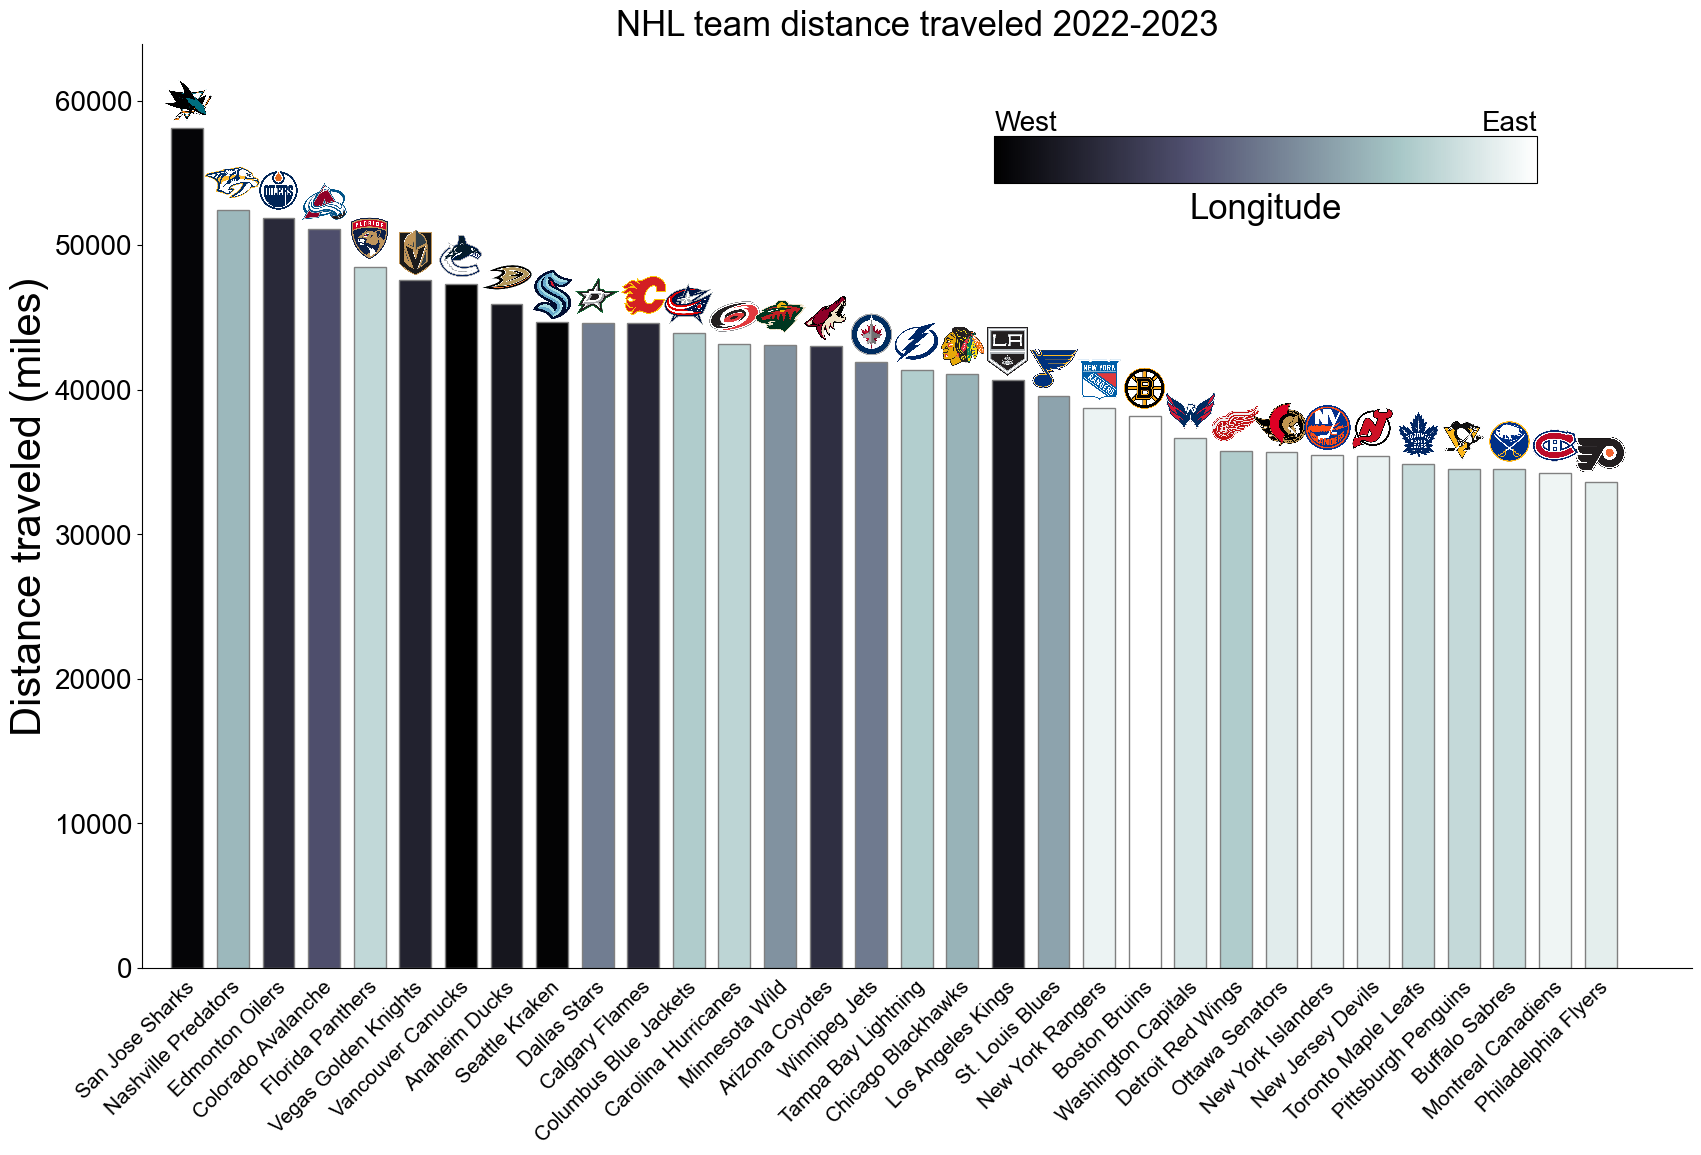

In [7]:
#Make distance bar plot.
cmap = matplotlib.cm.get_cmap('bone')
norm = matplotlib.colors.Normalize(vmin = min(df['longitude']),vmax = max(df['longitude']))

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(1,1,1)
im1 = plt.bar(np.linspace(0,nteams-1,num = len(df['team'])),df['distance_traveled'],
        label = df['team'],color = cmap(norm(df['longitude'])),width = 0.7, edgecolor = 'gray')
plt.xticks([])
plt.title('NHL team distance traveled '+str(int(year)-1)+'-'+year,fontsize = 25, fontname='Arial')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax.set_ylabel('Distance traveled (miles)',fontsize=30,fontname='Arial')
ax.set_xlim([-1,nteams+1])
ymax = max(df['distance_traveled'])*1.1
ax.set_ylim([0,ymax])
ax.tick_params(which = 'major', labelsize = 20)
for tick in ax.get_yticklabels():
    tick.set_fontname('Arial')

axins1 = ax.inset_axes([.55,.85,.35,.05])
axins1.text(0, 1.12, 'West',fontsize=20,fontname='Arial')
axins1.text(1.0, 1.12, 'East',fontsize=20,horizontalalignment = 'right',fontname='Arial')
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), cax=axins1, 
             orientation="horizontal")
cbar.set_ticks([])
cbar.set_label(label = 'Longitude',size=25,fontname='Arial')

#Insert team logos at top of each bar
t_off = -.01*ymax
doff = .03*ymax
ioff = .25
for i,team in enumerate(df['team']):
    team_str = (team.replace(' ','_') + '.webp').lower()
    image = plt.imread('/Users/paca7401/hockey_project/team_logos/' + team_str)
    im_zoom = 0.05
    #Nordiques PNG is a bit wider and needs to be scaled down
    if team_str == 'quebec_nordiques.webp':
        im_zoom = .03
    ax.add_artist(AnnotationBbox(
            OffsetImage(image,zoom=im_zoom), (i , df.iloc[i]['distance_traveled'] + doff),
            frameon=False) )
    ax.text(i+ioff, t_off, team, rotation = 45, horizontalalignment = 'right',
           verticalalignment = 'top', fontsize = 15, fontname='Arial')
    
plt.show()